# Visualize Data

In [84]:
import pandas as pd 
import warnings
import matplotlib.pyplot as plt 
from sklearn.model_selection import train_test_split
from sklearn.metrics import root_mean_squared_error , mean_absolute_error
import xgboost as xgb
print (xgb.__version__)
import numpy as np
import seaborn as sns 
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor
import lightgbm as lgb
warnings.filterwarnings('ignore')



2.1.2


In [85]:
df=pd.read_csv("./data/train.csv")
df_test=pd.read_csv("./data/test.csv")
df.shape,df_test.shape

((177024, 508), (3644, 507))

# Feature Engineering

### Keep only the hour instead of the time

In [86]:

time=df["time"]=[int(df["time"][i][:2])+int(df["time"][i][3:5])/60 for i in range(len(df["time"]))]
time_test=df_test["time"]=[int(df_test["time"][i][:2])+int(df_test["time"][i][3:5])/60 for i in range(len(df_test["time"]))]

In [87]:

bg_col=[col for col in df.columns if col.startswith('bg-')]
df[bg_col]=df[bg_col].interpolate(method='linear',axis=1)
df[bg_col]=df[bg_col].fillna(method='bfill',axis=1)
df_test[bg_col]=df_test[bg_col].fillna(method='ffill',axis=1)
df_test[bg_col]=df_test[bg_col].fillna(method='bfill',axis=1)

hr_col=[col  for col in df.columns if col.startswith('hr-')]
df[hr_col]=df[hr_col].fillna(method='ffill',axis=1)
df[hr_col]=df[hr_col].fillna(method='bfill',axis=1)
df_test[hr_col]=df_test[hr_col].interpolate(method='linear',axis=1)
df_test[hr_col]=df_test[hr_col].fillna(method='bfill',axis=1)

inc_col=[col  for col in df.columns if col.startswith('insulin-')]
df[inc_col]=df[inc_col].interpolate(method='linear',axis=1)
df[inc_col]=df[inc_col].fillna(method='bfill',axis=1)
df_test[inc_col]=df_test[inc_col].fillna(method='ffill',axis=1)
df_test[inc_col]=df_test[inc_col].fillna(method='bfill',axis=1)


print(df)

               id p_num       time  bg-5:55  bg-5:50  bg-5:45    bg-5:40  \
0           p01_0   p01   6.166667      9.6      9.6      9.6   9.633333   
1           p01_1   p01   6.416667      9.7      9.7      9.7   9.533333   
2           p01_2   p01   6.666667      9.2      9.2      9.2   9.033333   
3           p01_3   p01   6.916667      8.7      8.7      8.7   8.600000   
4           p01_4   p01   7.166667      8.4      8.4      8.4   8.300000   
...           ...   ...        ...      ...      ...      ...        ...   
177019  p12_25294   p12  23.583333      8.8      9.1      9.2   9.400000   
177020  p12_25295   p12  23.666667      9.1      9.2      9.4   9.800000   
177021  p12_25296   p12  23.750000      9.2      9.4      9.8  10.200000   
177022  p12_25297   p12  23.833333      9.4      9.8     10.2  10.400000   
177023  p12_25298   p12  23.916667      9.8     10.2     10.4  10.300000   

          bg-5:35  bg-5:30    bg-5:25  ...  activity-0:40  activity-0:35  \
0        9.

### Cumulated insulin at 00:00

In [88]:
insulin=df.filter(regex="insulin")
insulin_test=df_test.filter(regex="insulin")

In [89]:
mu = .1
target_x = 2
target_value = 0.8
sigma = np.sqrt(-(target_x - mu)**2 / (2 * np.log(target_value)))
def gaussian(x):
    return  np.exp(-((x - mu) ** 2) / (2 * sigma ** 2))
value={}
for col_name in insulin.columns:
    if col_name != "cumulated_insulin":
        x=int(col_name[8:9])+int(col_name[10:12])/60
        value[col_name]=gaussian(x)

cumulated_insulin=[0 for i in range(177024)]
cumulated_insulin_test=[0 for i in range(3644)]
for col_name in insulin.columns:
    if col_name != "cumulated_insulin":
        cumulated_insulin+=np.multiply(insulin[col_name],value[col_name])
        cumulated_insulin_test+=np.multiply(insulin_test[col_name],value[col_name])   

#df=df.drop(columns=df.filter(regex="insulin"))
df["cumulated_insulin"]=cumulated_insulin
df["cumulated_insulin"].fillna(-1,inplace=True)
df_test["cumulated_insulin"]=cumulated_insulin_test
print(cumulated_insulin)

0          1.526658
1          1.589647
2          1.645409
3          1.694081
4          1.735919
            ...    
177019    18.599551
177020    19.250397
177021    19.425045
177022    19.082213
177023    18.753670
Name: insulin-5:55, Length: 177024, dtype: float64


### Cumulated carbs

In [90]:
carbs=df.filter(regex="carbs")
carbs_test=df_test.filter(regex="carbs")

In [91]:
mu = 3
target_x = 1
target_value = 0.01
sigma = np.sqrt(-(target_x - mu)**2 / (2 * np.log(target_value)))
def gaussian(x):
    return  np.exp(-((x - mu) ** 2) / (2 * sigma ** 2))

cumulated_carbs=[0 for i in range(177024)]
cumulated_carbs_test=[0 for i in range(3644)]
value={}
for col_name in carbs.columns:
    if col_name != "cumulated_carbs":
        x=int(col_name[6:7])+int(col_name[8:10])/60
        value[col_name]=gaussian(x)

for col_name in carbs.columns:
    if col_name != "cumulated_carbs":
        cumulated_carbs+=np.multiply(carbs[col_name],value[col_name])
        cumulated_carbs_test+=np.multiply(carbs_test[col_name],value[col_name])   

#df=df.drop(columns=df.filter(regex="carbs"))
df["cumulated_carbs"]=cumulated_carbs
df_test["cumulated_carbs"]=cumulated_carbs_test
print(df["cumulated_carbs"])

0        NaN
1        NaN
2        NaN
3        NaN
4        NaN
          ..
177019   NaN
177020   NaN
177021   NaN
177022   NaN
177023   NaN
Name: cumulated_carbs, Length: 177024, dtype: float64


### Activities processing

In [92]:
data = {'activity': ['Indoor climbing','Run','Strength training','Swim','Bike','Dancing','Stairclimber','Spinning','Walking','HIIT','Outdoor Bike','Walk','Aerobic Workout','Tennis','Workout','Hike','Zumba','Sport','Yoga','Swimming','Weights','Running','CoreTraining','Cycling']}
data = pd.DataFrame(data)
unique_act={act:i+1 for i,act in enumerate(data['activity'].dropna().unique())}

df[[act for act in df.filter(regex="activity")]]=df.filter(regex="activity").fillna(-1)
df_test[[act for act in df.filter(regex="activity")]]=df_test.filter(regex="activity").fillna(-1)

for value,key in enumerate(unique_act):
    df=df.replace(key,value)
    df_test=df_test.replace(key,value)


### BG variance

In [93]:
bg=df.filter(regex='bg')
bg=bg.iloc[:,-14:-2]
variance_bg = bg.var(axis=1)
print(variance_bg)
df["bg_variance"]=variance_bg

0         0.498005
1         1.137778
2         1.200202
3         0.646263
4         0.245884
            ...   
177019    1.485152
177020    1.426288
177021    1.383864
177022    1.307500
177023    1.236061
Length: 177024, dtype: float64


In [94]:
df=df.fillna(-1)

carbs_1H=df.filter(regex='carbs')
carbs_1H=carbs_1H.iloc[:,-14:-1]
carbs_1H=carbs_1H.sum(axis=1)
carbs_1H = (carbs_1H - carbs_1H.mean()) / carbs_1H.std()
carbs_1H=np.log(np.add(carbs_1H,1))

insulin_2H=df.filter(regex='insulin')
insulin_2H=insulin_2H.iloc[:,-28:-1]
insulin_2H=insulin_2H.sum(axis=1)
insulin_2H = (insulin_2H - insulin_2H.mean()) / insulin_2H.std()
insulin_2H=np.log(np.add(insulin_2H,1))
insulin_2H.fillna(-1,inplace=True)

steps_1H=df.filter(regex="steps")
steps_1H=steps_1H.iloc[:,-14:-1]
steps_1H=steps_1H.sum(axis=1)
steps_1H = (steps_1H - steps_1H.mean()) / steps_1H.std()
steps_1H=np.log(np.add(steps_1H,1))

bg_mean=df.filter(regex="bg")
bg_mean=bg_mean.iloc[:,-14:-1]
bg_mean=bg_mean.mean(axis=1)
df["bg_mean"]=bg_mean


df["carbs_1H"]=carbs_1H
df["insulin_2H"]=insulin_2H
df["steps_1H"]=steps_1H

print("Nombre de NaN restants par colonne :")
print(df.isna().sum())

Nombre de NaN restants par colonne :
id             0
p_num          0
time           0
bg-5:55        0
bg-5:50        0
              ..
bg_variance    0
bg_mean        0
carbs_1H       0
insulin_2H     0
steps_1H       0
Length: 515, dtype: int64


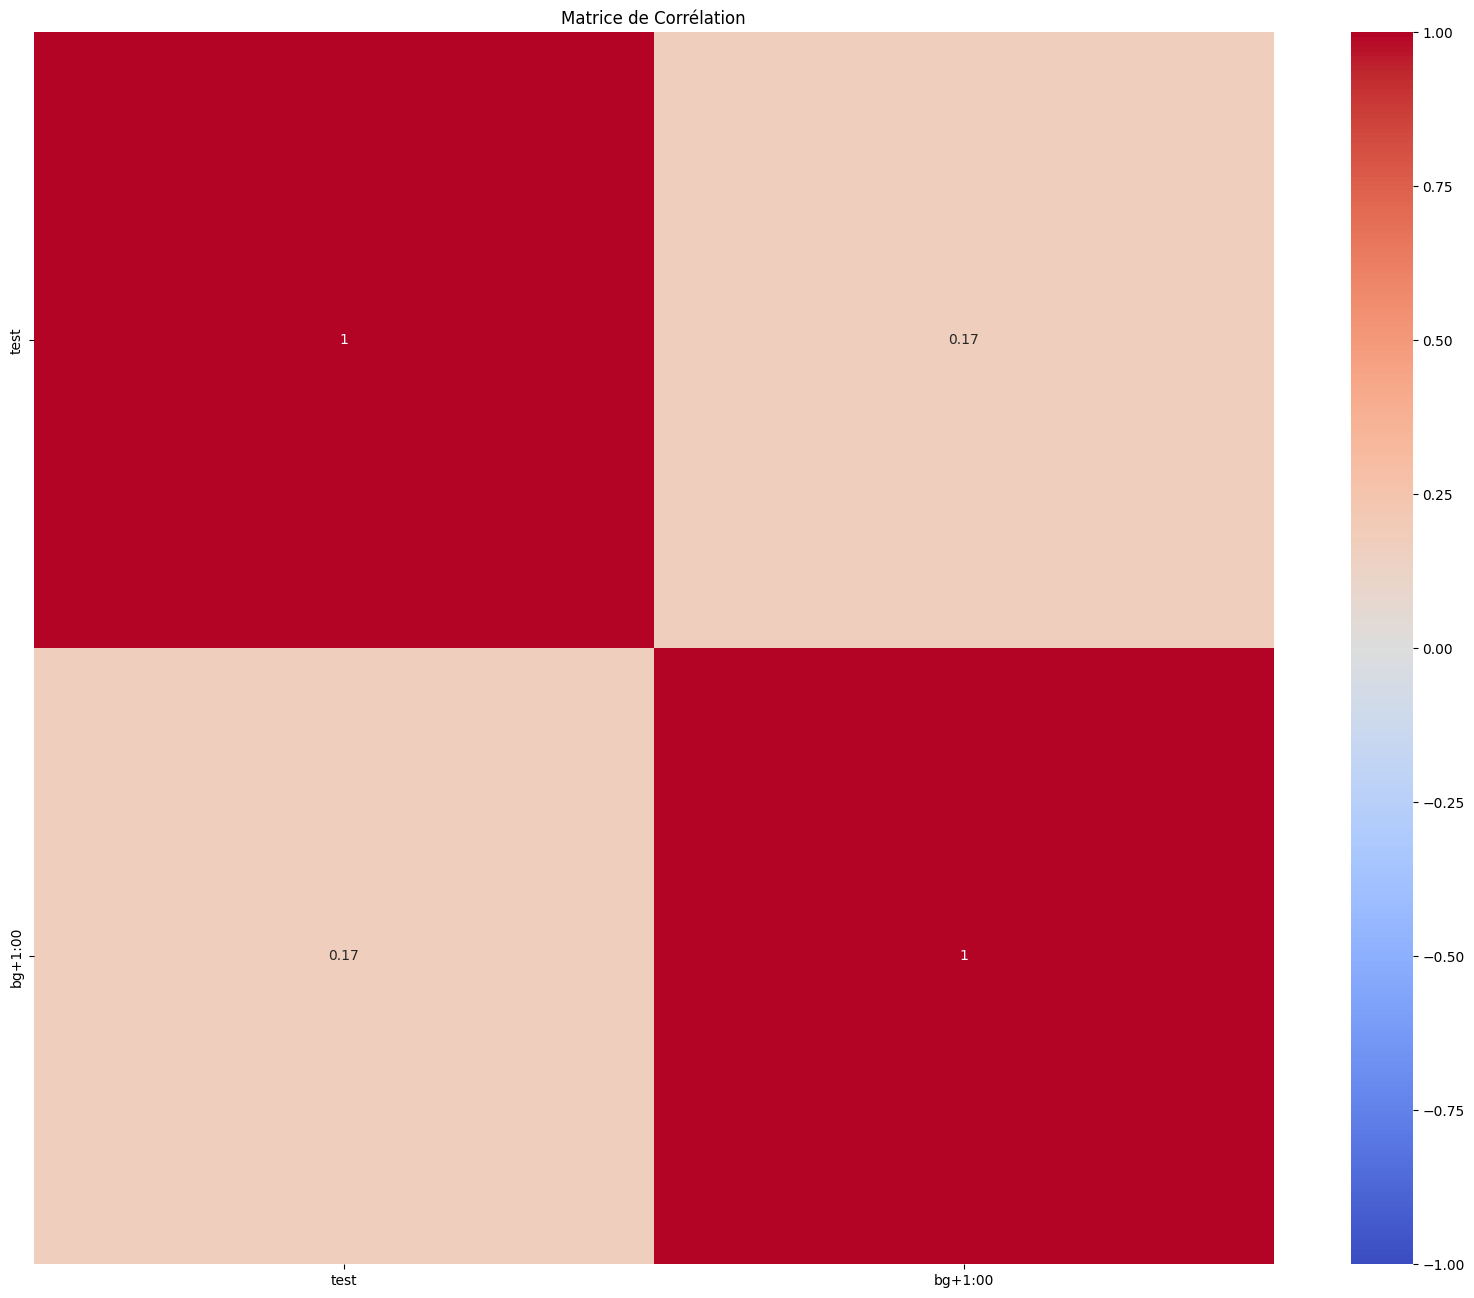

In [ ]:
p=pd.DataFrame()
#p=df
#p=p.drop(columns=["id","p_num","time"])
#p=p.filter(regex="cumulated_insulin")
p["test"]=cumulated_insulin_test
p["bg+1:00"]=df["bg+1:00"]
correlation=p.corr()

plt.figure(figsize=(20, 16))  # Taille de la figure
sns.heatmap(correlation, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title("Matrice de Corrélation")
plt.show()

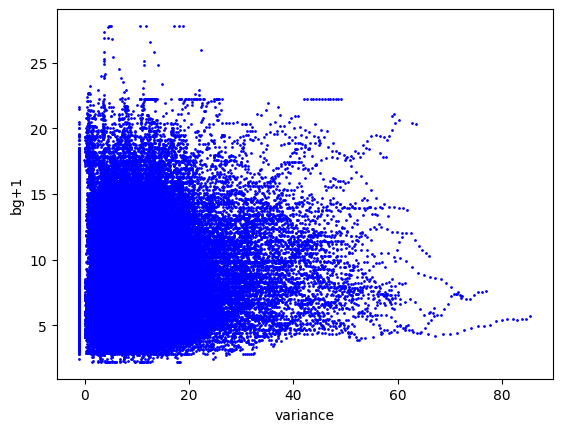

In [96]:
x=df["cumulated_insulin"]
y=df["bg+1:00"]
plt.scatter(x, y, color='blue', marker='o',s=1)

plt.xlabel('variance')
plt.ylabel('bg+1')
#plt.xlim(0, 1)

plt.show()

In [65]:
from sklearn.linear_model import LinearRegression

# Définition des variables X et Y
X = df[['bg-0:00', 'bg_variance','bg_mean','carbs_1H','steps_1H','insulin_2H','cumulated_insulin']]
Y = df['bg+1:00']

# Ajustement du modèle de régression multiple
model = LinearRegression().fit(X, Y)

# Affichage des coefficients de régression
print("Coefficients de corrélation pour X1 et X2 par rapport à Y :", model.coef_)
print("Score de corrélation globale du modèle (R²) :", model.score(X, Y))

Coefficients de corrélation pour X1 et X2 par rapport à Y : [ 7.04105624e-01  3.74723641e-03 -1.05204873e-04 -4.58777393e-02
  1.58273786e-01 -8.39840491e-01  4.02815388e-02]
Score de corrélation globale du modèle (R²) : 0.490167713239382


# XGBoost

### Data Prep

In [66]:
df=df.fillna(-1)
df_test=df_test.fillna(-1)
print(df)
df=df[['p_num','bg+1:00','id','bg-0:00', 'bg_variance','bg_mean','carbs_1H','steps_1H','insulin_2H','cumulated_insulin']]

target=df[["p_num","bg+1:00"]]
LoN=df[df["p_num"]=="p11"]
LoN_target=target[target["p_num"]=="p11"]
LoN_target=LoN_target.drop(columns=["p_num"])
LoN=LoN.drop(columns=["id","p_num","bg+1:00",])
LoN=LoN.drop(columns=df.filter(regex="activity"))
LoN=LoN.drop(columns=df.filter(regex="hr"))
LoN = LoN.sample(frac=1, random_state=42).reset_index(drop=True)

target=target[target["p_num"]!="p11"]
target=target.drop(columns=["p_num"])
df=df[df["p_num"]!="p11"]
data=df.drop(columns=["id","p_num","bg+1:00",])
data=data.drop(columns=df.filter(regex="activity"))
data=data.drop(columns=df.filter(regex="hr"))

x_train,x_val,y_train,y_val=train_test_split(data,target,test_size=0.15  ,random_state=42)

x_val,y_val = pd.concat([x_val, LoN], ignore_index=True),pd.concat([y_val, LoN_target], ignore_index=True)
x_val,y_val=x_val.sample(frac=1, random_state=42).reset_index(drop=True),y_val.sample(frac=1, random_state=42).reset_index(drop=True)

               id p_num       time  bg-5:55  bg-5:50  bg-5:45    bg-5:40  \
0           p01_0   p01   6.166667      9.6      9.6      9.6   9.633333   
1           p01_1   p01   6.416667      9.7      9.7      9.7   9.533333   
2           p01_2   p01   6.666667      9.2      9.2      9.2   9.033333   
3           p01_3   p01   6.916667      8.7      8.7      8.7   8.600000   
4           p01_4   p01   7.166667      8.4      8.4      8.4   8.300000   
...           ...   ...        ...      ...      ...      ...        ...   
177019  p12_25294   p12  23.583333      8.8      9.1      9.2   9.400000   
177020  p12_25295   p12  23.666667      9.1      9.2      9.4   9.800000   
177021  p12_25296   p12  23.750000      9.2      9.4      9.8  10.200000   
177022  p12_25297   p12  23.833333      9.4      9.8     10.2  10.400000   
177023  p12_25298   p12  23.916667      9.8     10.2     10.4  10.300000   

          bg-5:35  bg-5:30    bg-5:25  ...  activity-0:05  activity-0:00  \
0        9.

### Search best features

In [385]:
xgb_model2 = xgb.XGBRegressor(
    objective="reg:squarederror",
    n_estimators=1000,  
    learning_rate=0.1,
    max_depth=12,    
    subsample=0.8,
    colsample_bytree=0.8,
    #eval_metric=root_mean_squared_error,
    early_stopping_rounds=20,
    )


xgb_model2.fit(
    x_train, y_train,
    eval_set=[(x_val, y_val)],
    verbose=True
)


y_pred = xgb_model2.predict(x_train)

rmse=root_mean_squared_error(y_train, y_pred)

print("rmse:",rmse)

[0]	validation_0-rmse:2.96403
[1]	validation_0-rmse:2.87346
[2]	validation_0-rmse:2.81468
[3]	validation_0-rmse:2.77000
[4]	validation_0-rmse:2.73758
[5]	validation_0-rmse:2.71620
[6]	validation_0-rmse:2.70436
[7]	validation_0-rmse:2.69838
[8]	validation_0-rmse:2.70061
[9]	validation_0-rmse:2.70190
[10]	validation_0-rmse:2.70516
[11]	validation_0-rmse:2.71115
[12]	validation_0-rmse:2.71901
[13]	validation_0-rmse:2.72923
[14]	validation_0-rmse:2.73833
[15]	validation_0-rmse:2.74561
[16]	validation_0-rmse:2.75513
[17]	validation_0-rmse:2.76398
[18]	validation_0-rmse:2.77210
[19]	validation_0-rmse:2.78195
[20]	validation_0-rmse:2.78959
[21]	validation_0-rmse:2.79706
[22]	validation_0-rmse:2.80535
[23]	validation_0-rmse:2.81285
[24]	validation_0-rmse:2.81904
[25]	validation_0-rmse:2.82866
[26]	validation_0-rmse:2.83410
[27]	validation_0-rmse:2.83955
rmse: 1.766920155967948


In [386]:
models = {
    'adaboost': AdaBoostRegressor(n_estimators=20, random_state=42),
    'XGBoost': xgb.XGBRegressor(tree_method='hist', device='cuda', objective='reg:squarederror', n_estimators=30),
    'RandomForest': RandomForestRegressor(n_estimators=20, random_state=42, n_jobs=-1),

}

rmse_dict = {}
predictions = []

for name, model in models.items():
    model.fit(x_train, y_train)
    y_pred = model.predict(x_val)
    rmse = root_mean_squared_error(y_val, y_pred)
    rmse_dict[name] = rmse
    predictions.append(y_pred)
    print(f"{name} RMSE: {rmse:.4f}")

y_pred_ensemble = np.mean(predictions, axis=0)
rmse_ensemble = root_mean_squared_error(y_val, y_pred_ensemble)
print(f"Ensemble RMSE: {rmse_ensemble:.4f}")

adaboost RMSE: 2.8720
XGBoost RMSE: 3.0391
RandomForest RMSE: 2.9257
Ensemble RMSE: 2.8417


In [387]:
y_pred_val=xgb_model2.predict(x_val)
rmse=root_mean_squared_error(y_val, y_pred_val)
print("rmse:",rmse)

rmse: 2.6983845941455464


# Submission CSV

In [1221]:
data_test=df_test.drop(columns=["id","p_num"])
print(data_test)
#data_test=data_test.drop(columns=df.filter(regex="activity"))

#y_pred_test=xgb_model2.predict(data_test)


           time  bg-5:55  bg-5:50  bg-5:45  bg-5:40  bg-5:35  bg-5:30  \
0      6.750000      9.2      9.2      9.2      9.2     10.2     10.2   
1     11.416667      9.9      9.9      9.9      9.9      9.9      9.4   
2     14.750000      5.5      5.5      5.5      5.5      5.5      5.5   
3      4.500000      3.4      3.4      3.4      3.4      3.9      3.9   
4      4.333333      8.3      8.3      8.3      8.3      8.3     10.0   
...         ...      ...      ...      ...      ...      ...      ...   
3639   6.666667      7.3      7.3      7.1      6.7      6.8      6.8   
3640  12.500000      6.0      6.2      6.2      6.2      5.8      5.5   
3641   3.750000     12.4     12.5     12.7     13.1     13.2     13.3   
3642   6.166667      8.3      8.3      8.2      8.2      7.8      7.4   
3643   3.166667      9.9     10.1     10.0      9.9     10.0      9.7   

      bg-5:25  bg-5:20  bg-5:15  ...  activity-0:35  activity-0:30  \
0        10.2     10.3     10.3  ...             -1  

In [1223]:
y_pred_submission_xgb = models['XGBoost'].predict(data_test)
y_pred_submission_rf = models['RandomForest'].predict(data_test)
y_pred_submission_ab = models['adaboost'].predict(data_test)
y_pred_submission = (y_pred_submission_xgb + y_pred_submission_rf + y_pred_submission_ab) / 3

In [1224]:
#results={"id":df_test["id"],"bg+1:00":y_pred_test}
results={"id":df_test["id"],"bg+1:00":y_pred_submission_xgb}
submission=pd.DataFrame(results)
print(submission.shape)
submission.to_csv('submission.csv', index=False, encoding='utf-8')

(3644, 2)
